# Battery Remaining Useful Life (RUL) Prediction with Random Forest
Bertujuan untuk memprediksi Sisa Umur Pakai (Remaining Useful Life/RUL) baterai menggunakan model Random Forest. Proses yang akan kita lakukan:

1. Data Loading and Initial Cleaning
2. Exploratory Data Analysis (condensed)
3. Feature Selection and Preprocessing (including outlier handling and transformations)
4. Model Training
5. Model Evaluation
6. Feature Importance
7. Model Export

# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings

Mengimport setiap library yang dibutuhkan

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# 2. Load Data

In [4]:
try:
    df = pd.read_csv("../input/battery-remaining-useful-life-rul/Battery_RUL.csv")
except FileNotFoundError:
    print("Dataset file not found at ../input/battery-remaining-useful-life-rul/Battery_RUL.csv. Please check the path.")
    print("Attempting to load from local 'Battery_RUL.csv'...")
    try:
        df = pd.read_csv("Battery_RUL.csv")
        print("Successfully loaded 'Battery_RUL.csv' from local directory.")
    except FileNotFoundError:
        print("Local 'Battery_RUL.csv' not found. Please ensure the file is in the correct location.")
        # Exit or raise error if file is critical
        raise

Load dataset agar dapat diproses lebih lanjut

## 3. Initial Data Preparation

In [5]:
print("Original DataFrame shape:", df.shape)

Original DataFrame shape: (15064, 9)


Agar kita dapat mengetahui shape dari dataset yang kita ambil

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


Dataset memiliki total 15.064 row data.
Ada 9 columns atau fitur di dataset ini.
Semua kolom terlihat lengkap (tidak ada missing values) dengan jumlah 15064 non-null di setiap kolom. 

In [7]:
print("\nOriginal DataFrame head:\n", df.head())


Original DataFrame head:
    Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0          1.0             2595.30             1151.488500   
1          2.0             7408.64             1172.512500   
2          3.0             7393.76             1112.992000   
3          4.0             7385.50             1080.320667   
4          6.0            65022.75            29813.487000   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                      3.670                    3.211           5460.001   
1                      4.246                    3.220           5508.992   
2                      4.249                    3.224           5508.993   
3                      4.250                    3.225           5502.016   
4                      4.290                    3.398           5480.992   

   Time constant current (s)  Charging time (s)   RUL  
0                    6755.01           10777.82  1112  
1                    6762.02   

Melihat beberapa baris pertama dataset kita menggunakan df.head(). Tujuan utamanya mendapatkan gambaran awal tentang isi data, seperti contoh nilai di setiap kolom dan formatnya. Dari sini, kita bisa intip ada kolom Cycle_Index, Discharge Time (s), berbagai metrik tegangan dan waktu, sampai akhirnya kolom RUL yang jadi target. Ini penting, sebelum melakukan analisis.

In [8]:
print("\nOriginal DataFrame describe:\n", df.describe())


Original DataFrame describe:
         Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
count  15064.000000        15064.000000            15064.000000   
mean     556.155005         4581.273960             1239.784672   
std      322.378480        33144.012077            15039.589269   
min        1.000000            8.690000          -397645.908000   
25%      271.000000         1169.310000              319.600000   
50%      560.000000         1557.250000              439.239471   
75%      833.000000         1908.000000              600.000000   
max     1134.000000       958320.370000           406703.768000   

       Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
count               15064.000000             15064.000000       15064.000000   
mean                    3.908176                 3.577904        3768.336171   
std                     0.091003                 0.123695        9129.552477   
min                     3.043000             

Dari output df.describe(), kita bisa perhatikan beberapa hal untuk setiap kolom:

-Semua kolom memiliki 15.064 entri, yang mengkonfirmasi tidak ada missing values di data numerik.

-Menunjukkan seberapa tersebar data dari nilai rata-ratanya. Nilai std yang besar, seperti pada Discharge Time (s) (sekitar 4581) atau Decrement 3.6-3.4V (s) (sekitar 1239), mengindikasikan sebaran data yang lebar.

-Pada min dan max terlihat ada nilai yang aneh atau tidak masuk akal di sini (misalnya, nilai negatif untuk waktu atau tegangan yang seharusnya tidak ada).

-Terdapat beberapa kolom yang memiliki nilai min yang sangat kecil atau bahkan negatif, seperti Decrement 3.6-3.4V (s) (-397645.9) atau Time at 4.15V (s) (-113.584), yang perlu kita perhatikan. Ini bisa jadi indikasi adanya outlier atau data yang kurang valid, yang nantinya perlu ditangani.

-Jika nilai mean dan median jauh berbeda, ini bisa jadi indikasi distribusi data yang miring (skewed). Misalnya, pada Decrement 3.6-3.4V (s), mean sekitar 1239 sedangkan median hanya 439, ini jelas menunjukkan distribusi yang miring ke kanan. Begitu juga dengan Time at 4.15V (s) atau Time constant current (s).
KESIMPULAN:

-Dari output ini, kita bisa melihat bahwa meskipun tidak ada missing values, beberapa kolom memiliki distribusi yang sangat miring (terlihat dari perbedaan jauh antara mean dan median serta nilai std yang tinggi). Selain itu, ada potensi outlier di beberapa kolom seperti Decrement 3.6-3.4V (s) dan Time at 4.15V (s) karena adanya nilai minimum yang ekstrem atau negatif. Ini adalah informasi penting yang akan menjadi pertimbangan kita saat melakukan preprocessing data, misalnya dengan menggunakan RobustScaler atau Power Transform untuk menangani data yang miring dan outlier tersebut.



In [9]:
if 'Cycle_Index' in df.columns:
    df.drop(columns='Cycle_Index', inplace=True)
    print("\nDropped 'Cycle_Index' column.")


Dropped 'Cycle_Index' column.


Pada tahapan ini, kita menghapus kolom 'Cycle_Index' dari dataset. Column ini dihapus karena berpotensi data leakage dan kemungkinan berkorelasi sempurna dengan target 'RUL', yang dapat membuat model kita terlihat bagus di awal tapi ternyata aslinya buruk. Dengan membuang column ini, dapat dipastikan model akan belajar dari fitur yang benar-benar relevan dan tidak ada "bocoran" informasi, jadi prediksinya nanti lebih akurat.



In [10]:
df.drop(index=15063, inplace=True)
print("Dropped row with index 15063.")

print("\nDataFrame shape after initial drops:", df.shape)

Dropped row with index 15063.

DataFrame shape after initial drops: (15063, 8)


Row terakhir dihapus karena baris tersebut diidentifikasi sebagai baris ringkasan atau total, bukan data aktual yang dapat mengurangi performa model.



In [11]:
original_cols = df.columns.tolist()

In [12]:
if 'RUL' in original_cols:
    original_features = [col for col in original_cols if col != 'RUL']
    new_feature_labels = [f'F{i+1}' for i in range(len(original_features))]
    new_col_labels = new_feature_labels + ['RUL']
    
    if len(original_cols) == len(new_col_labels):
        df_column_dict = dict(zip(original_cols, new_col_labels))
        df.rename(columns=df_column_dict, inplace=True)
        print("\nColumns renamed:")
        print(df_column_dict)
    else:
        print("\nColumn length mismatch. Skipping renaming.")
else:
    print("\n'RUL' column not found. Skipping renaming based on RUL.")


Columns renamed:
{'Discharge Time (s)': 'F1', 'Decrement 3.6-3.4V (s)': 'F2', 'Max. Voltage Dischar. (V)': 'F3', 'Min. Voltage Charg. (V)': 'F4', 'Time at 4.15V (s)': 'F5', 'Time constant current (s)': 'F6', 'Charging time (s)': 'F7', 'RUL': 'RUL'}


Untuk mempermudah penanganan data, kita melakukan penamaan ulang kolom-kolom fitur. Tujuan utamanya adalah memastikan kolom 'RUL' tetap menjadi kolom terakhir dan semua fitur lainnya diberi nama generik seperti 'F1', 'F2', 'F3', dan seterusnya. Setelah proses ini, setiap column di dataset akan memiliki nama yang lebih terstruktur, seperti Discharge Time (s) menjadi 'F1', Decrement 3.6-3.4V (s) menjadi 'F2', dan begitu seterusnya hingga 'RUL' di akhir. RUL tidak diubah karena mempermudah kami dalam menetapkan RUL sebagai target column.

In [13]:
print("\nDataFrame head after renaming:\n", df.head())


DataFrame head after renaming:
          F1            F2     F3     F4        F5        F6        F7   RUL
0   2595.30   1151.488500  3.670  3.211  5460.001   6755.01  10777.82  1112
1   7408.64   1172.512500  4.246  3.220  5508.992   6762.02  10500.35  1111
2   7393.76   1112.992000  4.249  3.224  5508.993   6762.02  10420.38  1110
3   7385.50   1080.320667  4.250  3.225  5502.016   6762.02  10322.81  1109
4  65022.75  29813.487000  4.290  3.398  5480.992  53213.54  56699.65  1107


Handle Duplicates

In [14]:
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
rows_after_duplicates = df.shape[0]
print(f"\nDropped {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"DataFrame shape after dropping duplicates: {df.shape}")


Dropped 39 duplicate rows.
DataFrame shape after dropping duplicates: (15024, 8)


Menghilangkan data yang duplikat

Handle Negative Values

In [15]:
time_columns = []
if 'F1' in df.columns: time_columns.extend(['F1', 'F2', 'F5', 'F6', 'F7']) 

valid_time_columns = [col for col in time_columns if col in df.columns]

if valid_time_columns:
    rows_before_neg_filter = df.shape[0]
    for col in valid_time_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    df.dropna(subset=valid_time_columns, inplace=True) 

    df = df[(df[valid_time_columns] >= 0).all(axis=1)]
    rows_after_neg_filter = df.shape[0]
    print(f"\nDropped {rows_before_neg_filter - rows_after_neg_filter} rows with negative values in time columns {valid_time_columns}.")
    print(f"DataFrame shape after handling negative time values: {df.shape}")
else:
    print("\nSkipping negative time value handling as relevant F-columns are not present (check renaming step).")


Dropped 33 rows with negative values in time columns ['F1', 'F2', 'F5', 'F6', 'F7'].
DataFrame shape after handling negative time values: (14991, 8)


Langkah preprocessing ini penting untuk menjaga kualitas dan keandalan dari dataset-nya. Data negatif perlu dihapus karena secara logis tidak merepresentasikan nilai yang valid atau mungkin mengindikasikan error dalam pengukuran/pengumpulan data. Keberadaan data negatif pada fitur yang seharusnya positif (misalnya, nilai sensor, durasi, atau jumlah) dapat mengakibatkan bias pada model prediksi, performa model yang kurang optimal, dan interpretasi hasil yang keliru, karena model akan belajar dari pola data yang tidak realistis dan tidak konsisten dengan domain masalah yang ada.


## 4. Exploratory Data Analysis


DataFrame describe (post-cleaning):
                   F1             F2            F3            F4  \
count   14991.000000   14991.000000  14991.000000  14991.000000   
mean     4229.206765    1435.772970      3.907896      3.577714   
std     31465.065102   13763.906517      0.089842      0.122218   
min         8.690000      31.168831      3.043000      3.022000   
25%      1171.670000     320.666667      3.846000      3.488000   
50%      1557.500000     440.000000      3.906000      3.573000   
75%      1908.000000     601.210500      3.972000      3.663000   
max    958320.370000  406703.768000      4.363000      4.300000   

                  F5             F6             F7           RUL  
count   14991.000000   14991.000000   14991.000000  14991.000000  
mean     3681.977745    5290.314287    9900.930998    554.978587  
std      8821.961146   24095.322918   25446.019660    322.154045  
min        14.052000       5.980000       5.980000      0.000000  
25%      1836.343500   

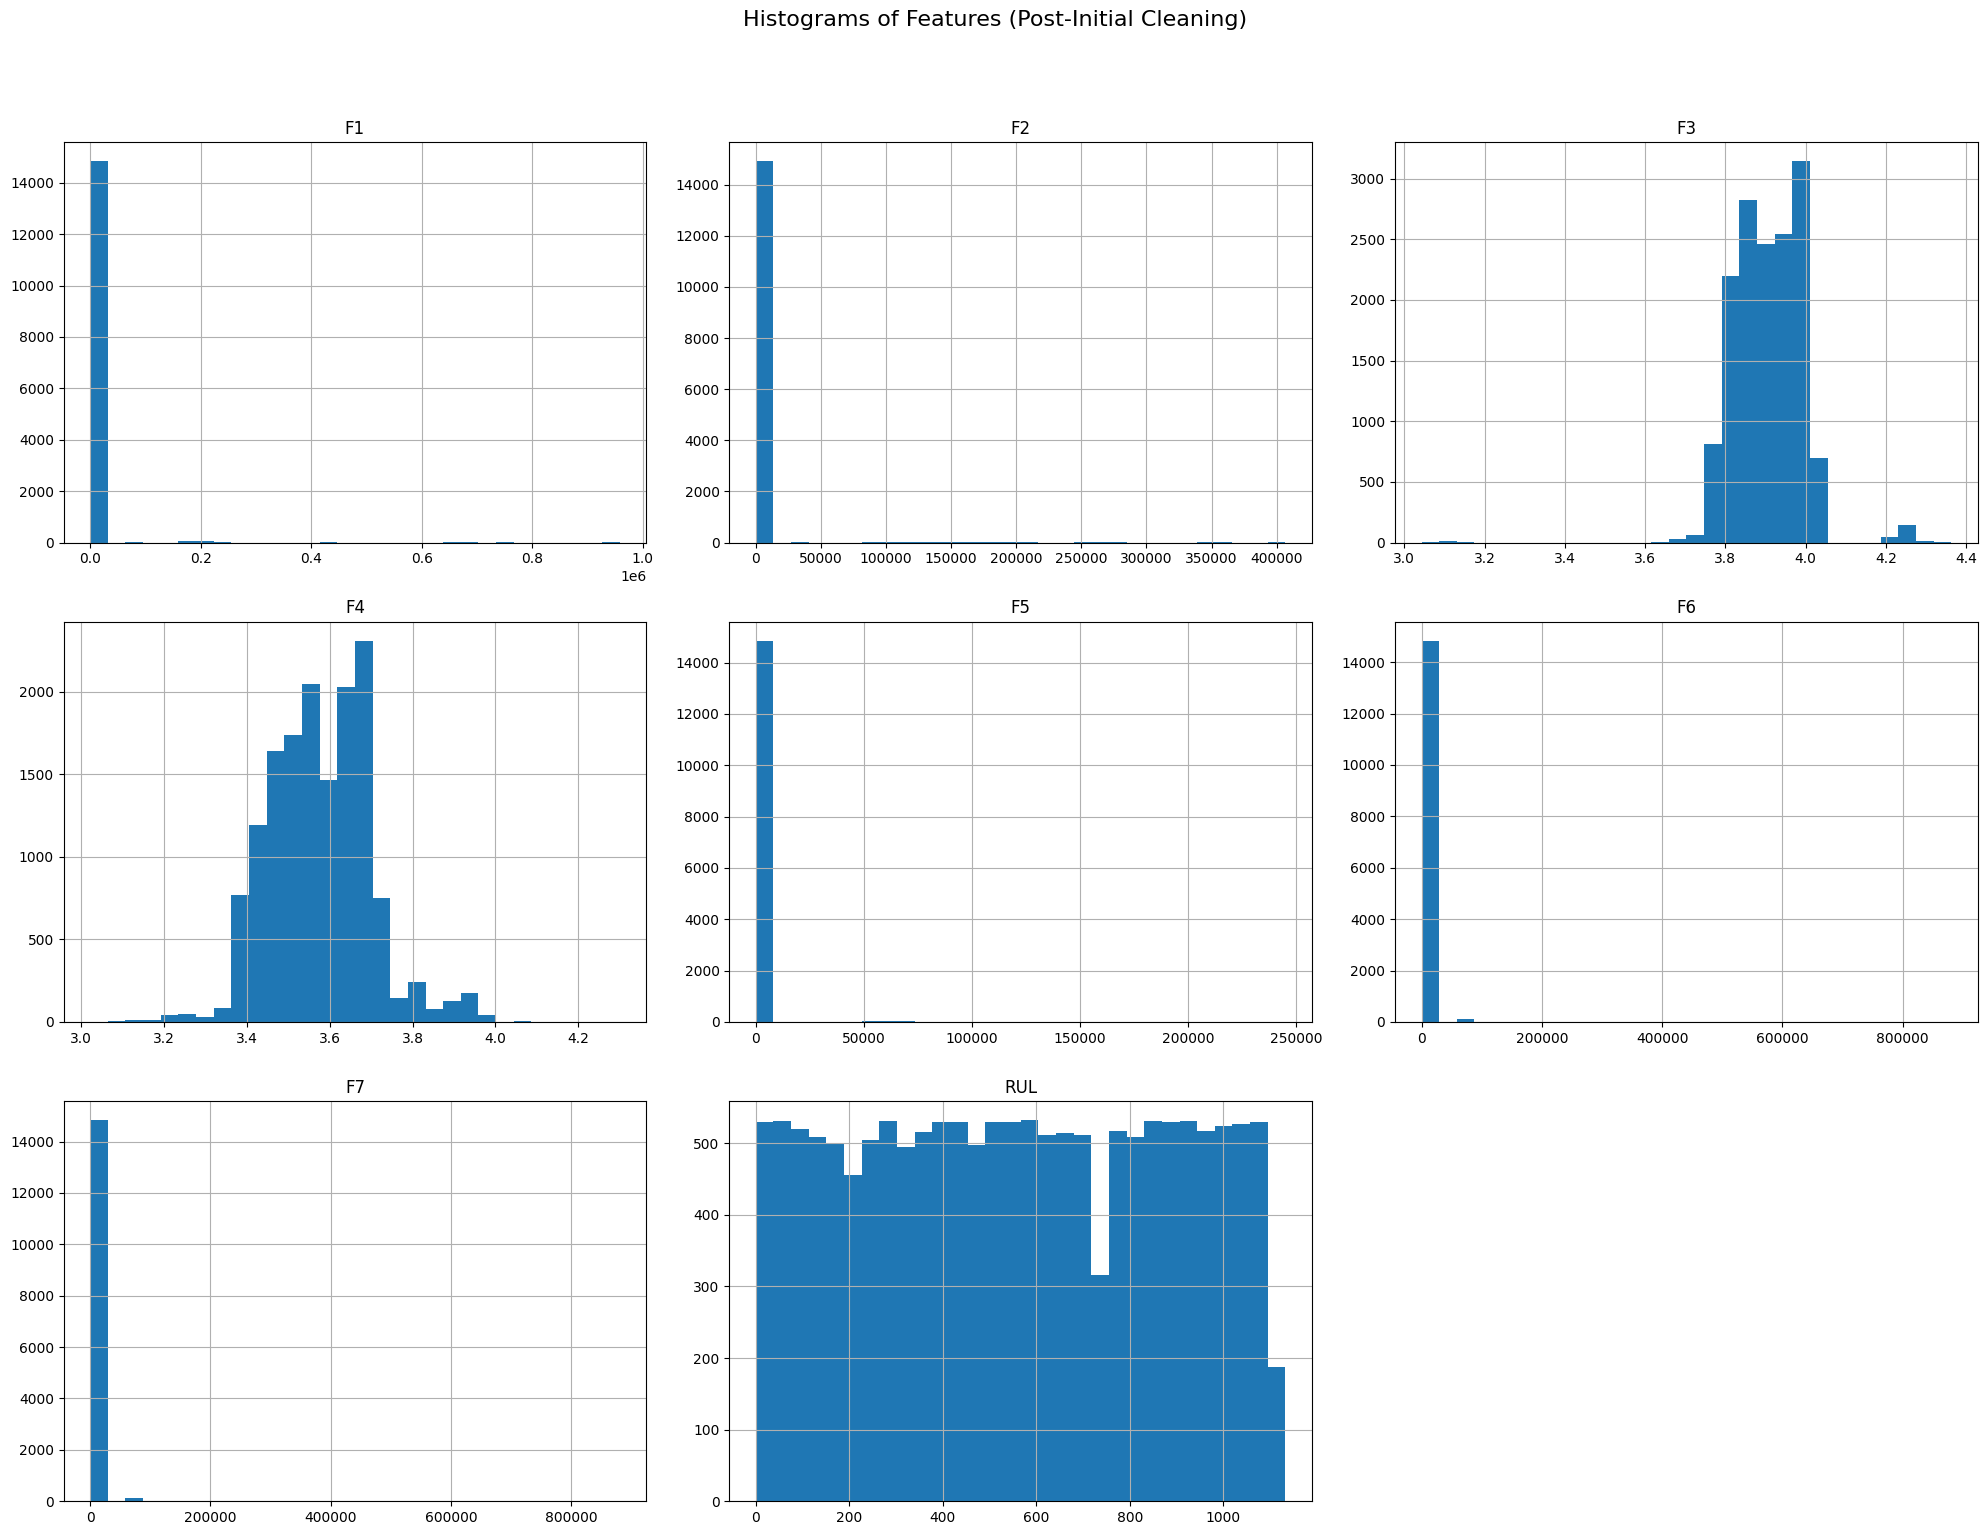

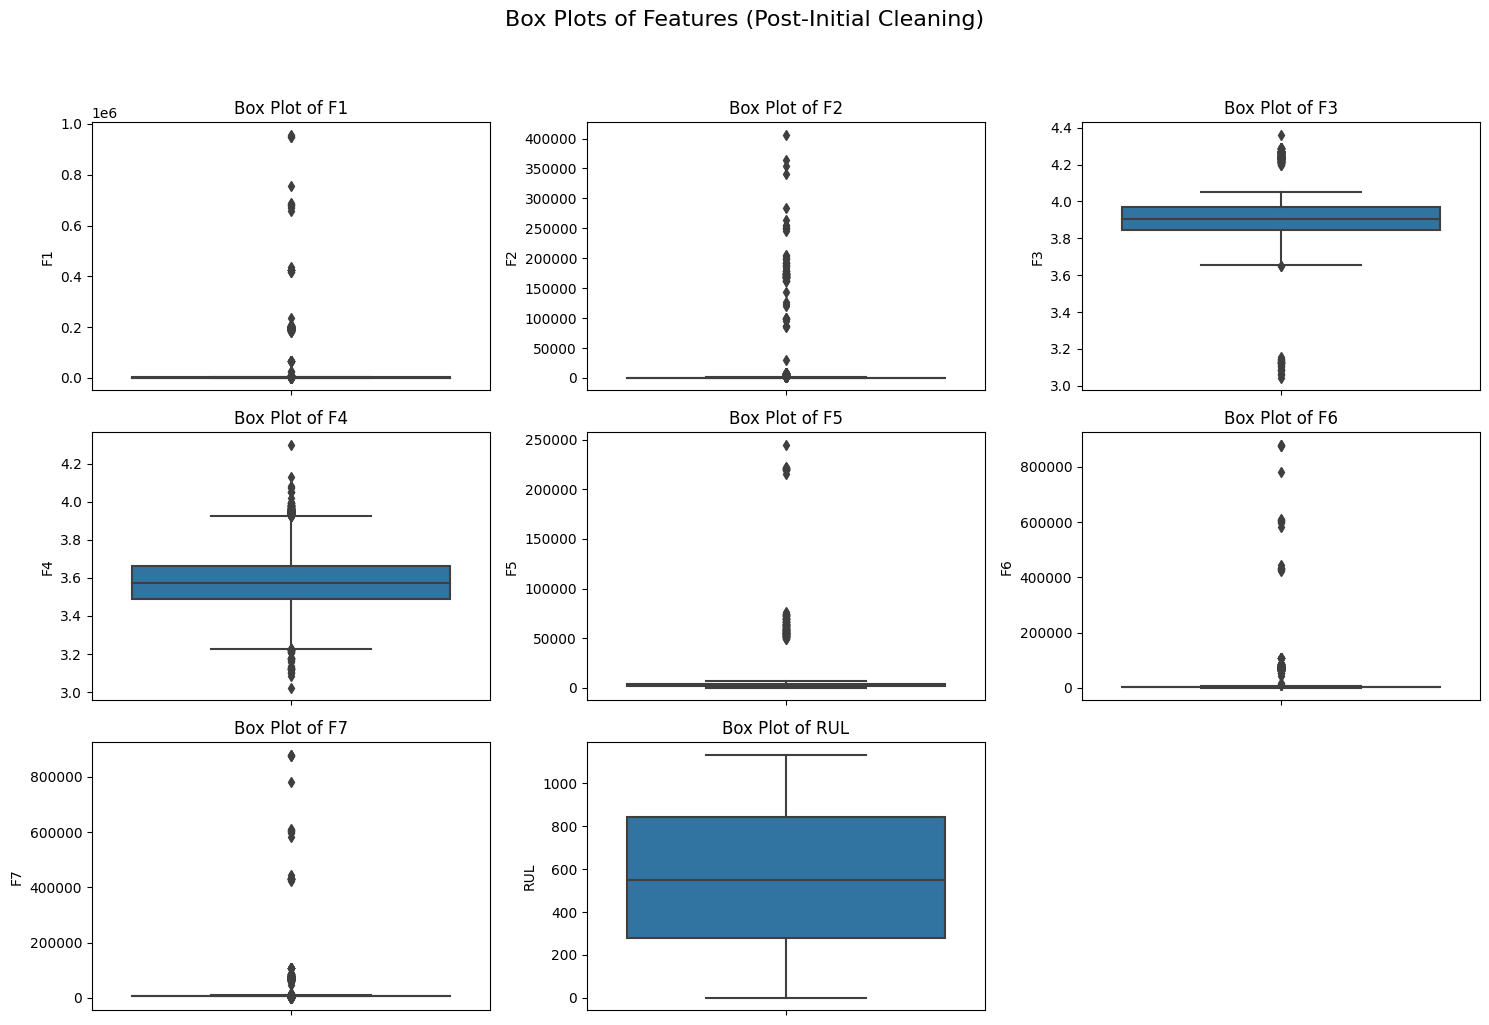

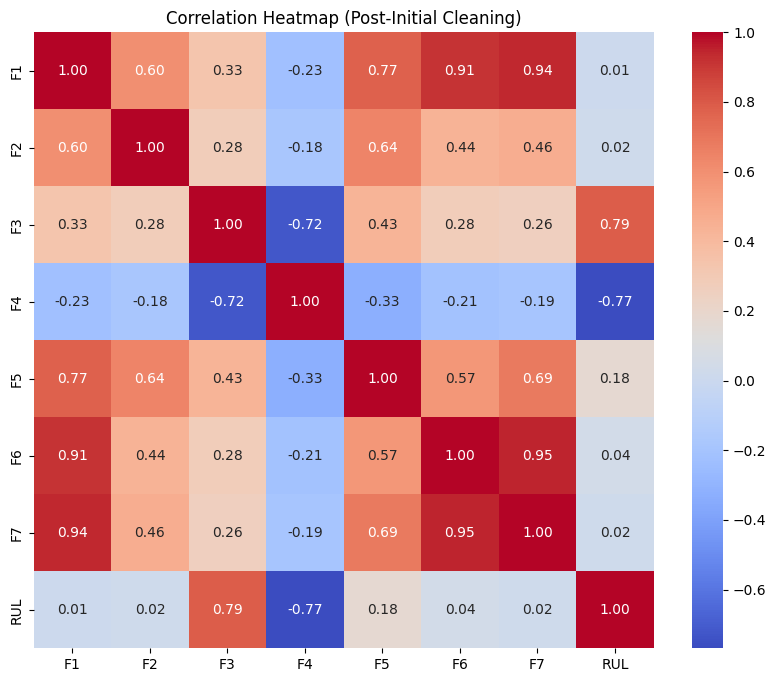

In [16]:
if not df.empty:
    print("\nDataFrame describe (post-cleaning):\n", df.describe())
    df.hist(bins=30, figsize=(20, 15), layout=(-1, 3))
    plt.suptitle("Histograms of Features (Post-Initial Cleaning)", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


    if len(df.columns) > 1 :
        num_cols_for_boxplot = min(len(df.columns), 9) # Limit to 9 plots for readability
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(df.columns[:num_cols_for_boxplot]):
            plt.subplot(3, 3, i + 1)
            sns.boxplot(y=df[col])
            plt.title(f"Box Plot of {col}")
        plt.suptitle("Box Plots of Features (Post-Initial Cleaning)", y=1.02, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()


    plt.figure(figsize=(10, 8))
    numeric_df_for_corr = df.select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        sns.heatmap(numeric_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation Heatmap (Post-Initial Cleaning)')
        plt.show()
    else:
        print("No numeric columns found for correlation heatmap after cleaning.")
else:
    print("DataFrame is empty after initial cleaning. Cannot perform EDA.")


Descriptive Statistics:
Dari sini, kita bisa lihat bahwa semua kolom memiliki 14.991 entri, menunjukkan tidak ada missing values lagi. Namun, kita perhatikan bahwa beberapa fitur seperti F1, F2, F5, F6, dan F7 punya rentang nilai yang sangat lebar (terlihat dari nilai max yang sangat besar) dan indikasi distribusi yang miring (skewed) karena perbedaan jauh antara mean dan median-nya. Ini penting untuk dicatat karena akan mempengaruhi bagaimana kita melakukan preprocessing selanjutnya.

Histograms of Features:
Plot ini dengan jelas menunjukkan kalau sebagian besar fitur, terutama F1, F2, F5, F6, dan F7, memiliki distribusi yang sangat miring ke kanan, yang mengonfirmasi apa yang kita lihat di df.describe(). Artinya, sebagian besar data terkumpul di nilai-nilai kecil, sementara ada beberapa nilai ekstrem di sisi kanan. Sementara itu, fitur F3 dan F4 terlihat punya distribusi yang lebih terpusat, meskipun masih ada beberapa data di ekornya. Ini memberikan gambaran visual yang kuat tentang skewness data kita.

Box Plots of Features:
Untuk lebih jelas melihat keberadaan outlier, kita gunakan box plot. Sesuai dugaan dari histogram, box plot ini secara eksplisit menampilkan banyak sekali titik outlier (titik-titik di luar "jangka" kotak) pada fitur-fitur seperti F1, F2, F5, F6, dan F7. Ini berarti ada banyak nilai ekstrem di data kita yang perlu ditangani. Untuk fitur F3 dan F4, meskipun distribusinya lebih baik, box plot tetap menunjukkan keberadaan outlier, meski tidak sebanyak fitur lainnya. Insight ini sangat penting untuk memilih strategi penanganan outlier dan scaling yang tepat nanti.

Correlation Heatmap:
Dapat dilihat korelasi antar fitur dan juga dengan kolom target 'RUL' melalui heatmap. Dari heatmap ini, kita bisa lihat beberapa pola menarik:

-Fitur F1, F6, F7, dan F5 punya korelasi positif yang sangat kuat satu sama lain (nilainya mendekati 1.00). Ini mengindikasikan mereka mungkin mengukur aspek yang serupa atau saling terkait.

-Fitur F3 menunjukkan korelasi positif yang cukup kuat dengan RUL (sekitar 0.79). Artinya, semakin tinggi nilai F3, cenderung semakin tinggi pula nilai RUL.
Sebaliknya, fitur F4 punya korelasi negatif yang lumayan kuat dengan RUL (sekitar -0.77). Ini berarti semakin tinggi nilai F4, RUL cenderung semakin rendah.

-Fitur lainnya (F1, F2, F5, F6, F7) punya korelasi yang cenderung lemah atau sangat lemah dengan RUL. 

# 5. Feature Selection & Further Preprocessing
Based on original EDA insights (not fully reproduced here for brevity, but guiding the selection):
- `F3` (Max. Voltage Dischar. (V))
- `F4` (Min. Voltage Charg. (V))
- `F5` (Time at 4.15V (s))
were identified as potentially good candidates. `RUL` is the target.

In [17]:
potential_features = ['F3', 'F4', 'F5']
target_col = 'RUL'

In [18]:
selected_features = [col for col in potential_features if col in df.columns]

Berdasarkan insight dari EDA sebelumnya, kita memilih F3, F4, dan F5 sebagai fitur-fitur penting yang akan digunakan untuk memprediksi 'RUL'. Ini adalah langkah kunci untuk fokus pada data yang paling relevan.

In [19]:
if not selected_features:
    print(f"Error: None of the potential features {potential_features} are in the DataFrame columns: {df.columns.tolist()}. Stopping.")
    df_model = pd.DataFrame() # Empty df to avoid later errors
else:
    print(f"\nSelected features for modeling: {selected_features}")
    if target_col not in df.columns:
        print(f"Error: Target column '{target_col}' not found in DataFrame. Stopping.")
        # raise ValueError("Target column not found.")
        df_model = pd.DataFrame()
    else:
        df_model = df[selected_features + [target_col]].copy()
        print(f"Shape of df_model before outlier removal: {df_model.shape}")


Selected features for modeling: ['F3', 'F4', 'F5']
Shape of df_model before outlier removal: (14991, 4)


Setelah fitur-fitur penting terpilih (F3, F4, F5), langkah selanjutnya adalah mempersiapkan dataframe khusus yang hanya berisi fitur-fitur terpilih dan kolom target ('RUL'). Kita bikin df_model ini supaya lebih fokus dan tidak membawa kolom lain yang tidak relevan saat proses pemodelan. Hasilnya, df_model kita sekarang berukuran (14991, 4), yang berarti kita punya 14991 row dengan 3 features dan 1 target yang siap untuk digunakan selanjutnya.

Outlier Handling for Selected Features using IQR

In [20]:
if not df_model.empty:
    print("\nApplying IQR-based outlier removal to selected features...")
    for col in selected_features: # Iterate over F3, F4, F5
        if col in df_model.columns: # Ensure column exists
            Q1 = df_model[col].quantile(0.25)
            Q3 = df_model[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            rows_before = df_model.shape[0]
            df_model = df_model[(df_model[col] >= lower_bound) & (df_model[col] <= upper_bound)]
            rows_after = df_model.shape[0]
            print(f"  Feature '{col}': Removed {rows_before - rows_after} outliers. Shape is now {df_model.shape}")
        else:
            print(f"  Warning: Column {col} for outlier removal not found in df_model.")
    print(f"DataFrame shape after outlier removal: {df_model.shape}")
else:
    print("df_model is empty. Skipping outlier handling.")


Applying IQR-based outlier removal to selected features...
  Feature 'F3': Removed 232 outliers. Shape is now (14759, 4)
  Feature 'F4': Removed 230 outliers. Shape is now (14529, 4)
  Feature 'F5': Removed 0 outliers. Shape is now (14529, 4)
DataFrame shape after outlier removal: (14529, 4)


Pada tahapan ini, kita berfokus pada penanganan outlier di dataset dengan menggunakan metode Interquartile Range (IQR). Tujuannya jelas, untuk membuang nilai-nilai ekstrem yang bisa mengganggu analisis dan performa model kita. Prosesnya cukup sistematis: untuk setiap fitur yang sudah kita targetkan ('F3', 'F4', dan 'F5'), kita hitung Q1, Q3, dan IQR lalu menetukan batas bawah dan atasnya. Setiap data yang nilainya jauh di luar batas ini akan otomatis teridentifikasi sebagai outlier dan dihapus. Dari hasil yang muncul, kita bisa tahu bahwa fitur 'F3' kehilangan 232 outlier dan 'F4' kehilangan 230 outlier, sedangkan 'F5' ternyata bersih dari outlier. Dengan begitu, dataset kita sekarang lebih rapi, ukurannya jadi (14529, 4), dan siap untuk tahap selanjutnya.

In [21]:
if df_model.empty or target_col not in df_model.columns or not selected_features:
    print("\nCannot proceed to model training due to missing data or features.")
else:
    X = df_model.drop(target_col, axis=1)
    y = df_model[target_col]
    print("\nShape of X (features):", X.shape)
    print("Shape of y (target):", y.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)

    std_scale_features = [col for col in ['F3', 'F4'] if col in X_train.columns]
    power_transform_features = [col for col in ['F5'] if col in X_train.columns]
    
    transformers_list = []
    if std_scale_features:
        transformers_list.append(('std_scaler', StandardScaler(), std_scale_features))
    if power_transform_features:
        transformers_list.append(('power_transform', PowerTransformer(method='yeo-johnson'), power_transform_features))

    if not transformers_list:
        print("Warning: No features identified for scaling or transformation. Preprocessor will be empty.")
        preprocessor = 'passthrough' 
    else:
        preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')



Shape of X (features): (14529, 3)
Shape of y (target): (14529,)

Shape of X_train: (11623, 3)
Shape of X_test: (2906, 3)


Setelah outlier dihilangkan, selanjutnya kita mempersiapkan data sebelum masuk ke model. Data tersebut kita split train (80) dan test (20) = (rasio 80:20). Selain itu, kita juga mendefinisikan fitur mana saja yang perlu di-scaling ('F3' dan 'F4' dengan StandardScaler karena metrik tegangan) dan mana yang perlu di-transform ('F5' dengan PowerTransformer karena distribusinya miring). Setelah itu kita gabungkan dalam ColumnTransformer, memastikan setiap fitur mendapatkan preprocessing yang tepat sebelum data masuk ke model.

# 6. Model Training (Random Forest)

In [22]:
if 'X_train' not in locals() or X_train.empty:
    print("\nTraining data (X_train) is not available or empty. Skipping model training.")
else:
    
    if not transformers_list: 
        print("No specific column transformers defined (transformers_list is empty). Applying StandardScaler to all features as a default.")
        model_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])
    else: 
        print("Using defined ColumnTransformer for preprocessing.")
        model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_split=5, oob_score=True))
        ])

    print("\nTraining Random Forest Regressor model...")
    model_pipeline.fit(X_train, y_train)
    print("Model training complete.")
    current_regressor = model_pipeline.named_steps['regressor']
    if hasattr(current_regressor, 'oob_score') and current_regressor.oob_score: 
        if hasattr(current_regressor, 'oob_score_'):
            print(f"OOB Score: {current_regressor.oob_score_:.4f}")
        else:
            print("OOB Score was set to True, but the oob_score_ attribute was not found.")

Using defined ColumnTransformer for preprocessing.

Training Random Forest Regressor model...
Model training complete.
OOB Score: 0.9882


Setelah selesai melakukan preprocessing dan data sudah siap untuk digunakan,
kita melakukan:


-Membangun sebuah pipeline model yang mengintegrasikan langkah preprocessing dengan model Random Forest. Ini penting agar semua langkah (dari scaling atau transformasi hingga prediksi) berjalan otomatis dan konsisten.

Setelah langkah preprocessing, barulah model DIjalankan. Kita atur n_estimators=100 (jumlah decision tree yang digunakan), random_state=42, max_depth=10 (untuk mencegah overfitting), min_samples_split=5, dan oob_score=True (untuk mengestimasi performa model tanpa perlu Cross Validation terpisah).


Proses Training Model:
-Pipeline model yang sudah disiapkan akan ditraining menggunakan train data. Proses ini akan membuat model belajar pola dari data untuk bisa melakukan prediksi.

Evaluasi OOB Score:
Setelah model selesai dilatih, kita akan melihat nilai OOB (Out-Of-Bag) Score. OOB Score ini sangat berguna di Random Forest karena memberikan estimasi performa model pada data yang tidak digunakan saat membangun setiap tree

Hasil:
Mendapatkan OOB Score sebesar 0.9882. Nilai ini menunjukkan bahwa model memiliki performa yang sangat baik dalam memprediksi Battery Remain Use Life berdasarkan data pelatihan, karena skor mendekati 1 menandakan prediksi yang sangat akurat.

# 7. Model Evaluation


Evaluating model performance...
Mean Absolute Error (MAE): 22.27
Mean Squared Error (MSE): 1158.75
Root Mean Squared Error (RMSE): 34.04
R-squared (R²): 0.9888


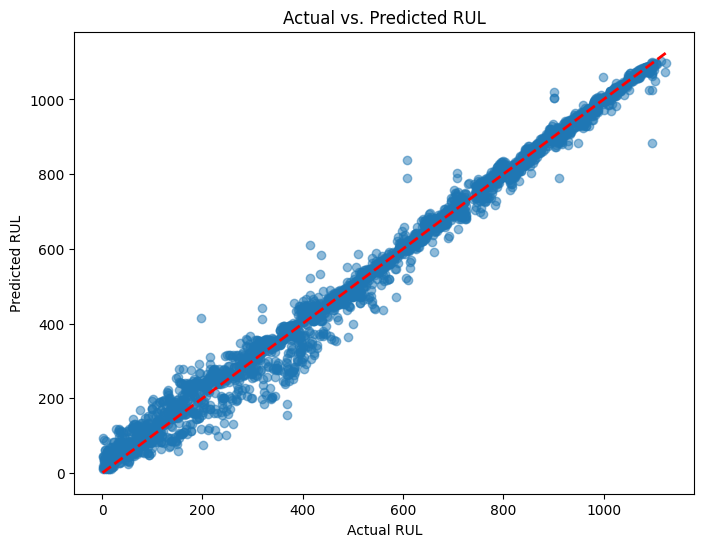

In [23]:
if 'model_pipeline' in locals() and 'X_test' in locals() and not X_test.empty:
    print("\nEvaluating model performance...")
    y_pred = model_pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Actual RUL")
    plt.ylabel("Predicted RUL")
    plt.title("Actual vs. Predicted RUL")
    plt.show()
else:
    print("\nModel or test data not available. Skipping model evaluation.")

Berdasarkan output evaluasi model yang telah kita jalankan, terlihat jelas bahwa model prediksi Remaining Useful Life (RUL) yang telah dikembangkan menunjukkan kinerja yang sangat baik.

Mengacu pada metrik evaluasi yang dihasilkan:

R-squared (R²): 0.9888
Nilai R² yang mencapai 0.9888, ini berarti model kita mampu menjelaskan hampir 99% dari total variasi pada nilai RUL aktual. Angka ini secara kuat menunjukkan bahwa model telah berhasil menangkap sebagian besar pola dan hubungan yang ada dalam data untuk memprediksi RUL dengan presisi tinggi.

Mean Absolute Error (MAE): 22.27
Dengan MAE sebesar 22.27, ini mengindikasikan bahwa, secara rata-rata, prediksi RUL model kita memiliki deviasi absolut sekitar 22.27 unit dari nilai RUL yang sebenarnya. Dalam konteks rentang RUL yang luas (0 hingga 1133 unit, sebagaimana terlihat dari analisis EDA sebelumnya), nilai MAE ini menunjukkan tingkat akurasi yang baik.

Root Mean Squared Error (RMSE): 34.04
RMSE sebesar 34.04 menunjukkan rata-rata magnitudo kesalahan prediksi model dalam satuan RUL. Perlu dicatat bahwa RMSE sedikit lebih tinggi dari MAE, yang mengindikasikan bahwa meskipun sebagian besar prediksi sangat akurat, mungkin ada beberapa kasus di mana model menghasilkan kesalahan prediksi yang relatif lebih besar.

Mean Squared Error (MSE): 1158.75
MSE sebesar 1158.75 merupakan nilai kuadrat dari RMSE, yang digunakan dalam perhitungan dan optimasi model.


Implikasi dari Output Ini:

Metrik evaluasi ini menegaskan bahwa model prediksi RUL kami bekerja dengan sangat baik. Kemampuan model untuk menjelaskan hampir seluruh variasi RUL (R² tinggi) dan menjaga tingkat kesalahan rata-rata yang rendah (MAE dan RMSE yang kompetitif) adalah bukti keberhasilan dalam menangkap dinamika data yang kompleks.

Visualisasi "Actual vs. Predicted RUL":

Grafik scatter plot dari Actual RUL vs. Predicted RUL juga secara visual mendukung kesimpulan ini. Titik-titik data tersebar sangat rapat di sekitar garis diagonal merah, yang merepresentasikan prediksi sempurna. Ini mengkonfirmasi bahwa model memiliki konsistensi yang kuat dalam memprediksi RUL di seluruh rentang nilai, dari RUL rendah hingga tinggi. Adanya beberapa titik yang sedikit menyimpang dari garis mengonfirmasi adanya kesalahan yang lebih besar yang tercermin pada nilai RMSE yang lebih tinggi.
Kesimpulan:

Secara ringkas, hasil evaluasi menunjukkan bahwa model kami memiliki kinerja yang robust dan dapat diandalkan untuk memprediksi Batteries Remaining Useful Life.

# 8. Feature Importance


Extracting and displaying feature importances...

Feature Importances:
                Feature  Importance
2  power_transform__F5    0.980336
0       std_scaler__F3    0.013512
1       std_scaler__F4    0.006152


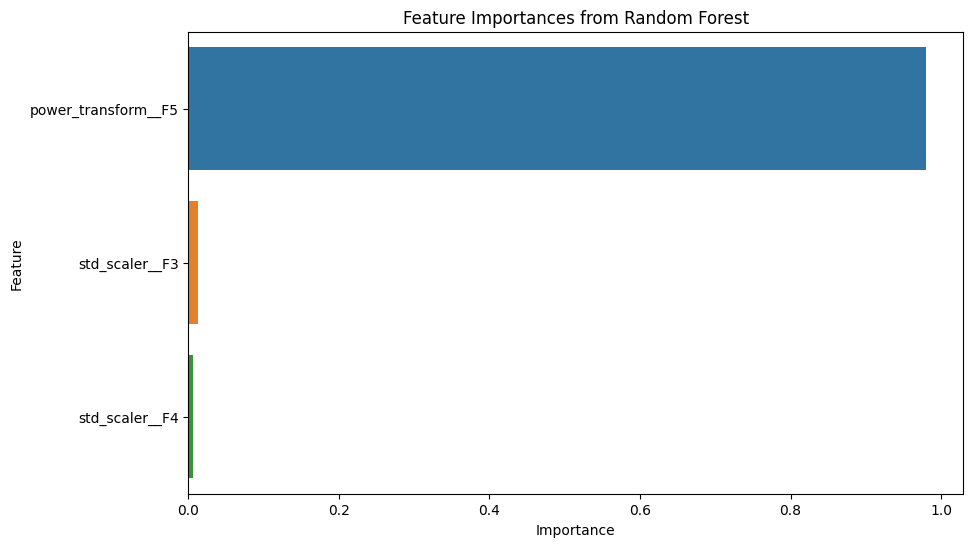

In [24]:
if 'model_pipeline' in locals() and 'regressor' in model_pipeline.named_steps and hasattr(model_pipeline.named_steps['regressor'], 'feature_importances_'):
    print("\nExtracting and displaying feature importances...")
    
    try:
        if 'preprocessor' in model_pipeline.named_steps and isinstance(model_pipeline.named_steps['preprocessor'], ColumnTransformer):
            feature_names_transformed = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
        elif 'scaler' in model_pipeline.named_steps: # If a simple scaler was used
             feature_names_transformed = X_train.columns.tolist()
        else: 
            feature_names_transformed = X_train.columns.tolist()


        importances = model_pipeline.named_steps['regressor'].feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names_transformed,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances:\n", feature_importance_df)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
        plt.title('Feature Importances from Random Forest')
        plt.show()
        
    except Exception as e:
        print(f"Could not retrieve feature names from ColumnTransformer: {e}")
        print("Displaying importances with generic names based on X_train.columns:")
        importances = model_pipeline.named_steps['regressor'].feature_importances_
        feature_names_original = X_train.columns.tolist() # Original feature names before transformation

        if len(importances) == len(feature_names_original):
            feature_importance_df = pd.DataFrame({
                'Feature': feature_names_original,
                'Importance': importances
            }).sort_values(by='Importance', ascending=False)
            print("\nFeature Importances (using original feature names):\n", feature_importance_df)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
            plt.title('Feature Importances from Random Forest (Original Features)')
            plt.show()
        else:
            print(f"Mismatch between number of importances ({len(importances)}) and original feature names ({len(feature_names_original)}).")


else:
    print("\nModel or feature importances not available. Skipping feature importance display.")


Setelah melakukan training model, kita mencari fitur mana yang paling berpengaruh dalam membuat prediksi Battery Remain Use Life. Kita dapat melihat nilai feature importances dari model, yang pada dasarnya menunjukkan seberapa besar kontribusi setiap fitur. Hasilnya sangat jelas, power_transform__F5 punya kontribusi yang sangat dominan dengan nilai importance sekitar 0.989336, menjadikannya prediktor paling kuat. Sementara itu, std_scaler__F3 dan std_scaler__F4 punya kontribusi yang sangat amat jauh lebih kecil. Ini berarti fitur 'F5' adalah kunci utama dalam menentukan sisa umur baterai.

# 9. Model Export

In [25]:
if 'model_pipeline' in locals():
    model_filename = 'rul_model_pipeline.joblib'
    joblib.dump(model_pipeline, model_filename)
    print(f"\nTrained model pipeline saved to '{model_filename}'")
else:
    print("\nModel not trained. Skipping model export.")


Trained model pipeline saved to 'rul_model_pipeline.joblib'


Menyimpan pipeline model

--- Feature Value Guidance (from Training Data X_train) ---
                 F3            F4            F5
count  11623.000000  11623.000000  11623.000000
mean       3.905972      3.576440   2991.233039
std        0.073192      0.108379   1221.117307
min        3.674000      3.355000    471.906000
25%        3.848000      3.492000   1859.784071
50%        3.906000      3.573000   2936.344000
75%        3.970000      3.661000   4061.913000
max        4.053000      3.917000   6826.609250
--------------------------------------------------

Enter your custom feature values below:


Enter value for F3 (Max. Voltage Dischar. (V)) [e.g., 3.91]:  2
Enter value for F4 (Min. Voltage Charg. (V))  [e.g., 3.58]:  0.8
Enter value for F5 (Time at 4.15V (s))     [e.g., 2991]:  1200



--- Custom Input DataFrame ---
    F3   F4      F5
0  2.0  0.8  1200.0
--------------------------------------------------

--- Prediction ---
Predicted RUL: 41 cycles
--------------------------------------------------
Battery condition based on predicted RUL: Good: The battery is in good condition and has a lot of cycles left.


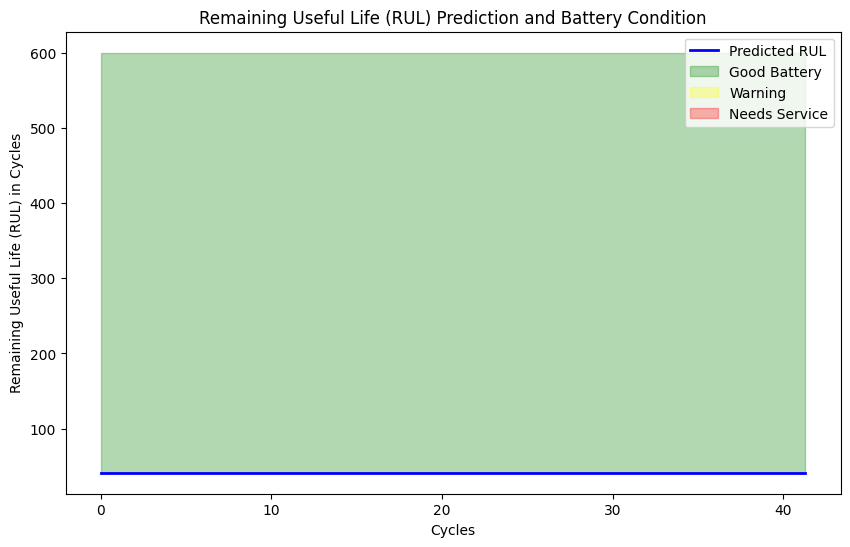


--- Line Plot Explanation ---
This line plot visualizes the predicted Remaining Useful Life (RUL) of the battery.
The battery is considered: Good: The battery is in good condition and has a lot of cycles left.
As we can see, the battery's health is depicted by different color-coded sections: Green for good condition, Yellow for warning, and Red for critical condition.



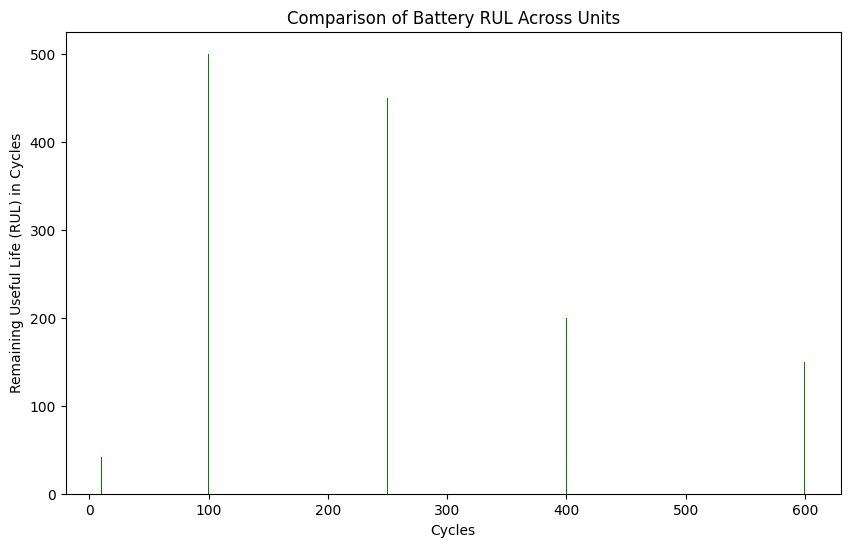


--- Bar Chart Explanation ---
This bar chart compares the predicted RUL of multiple battery units at different cycle points.
The color of the bars indicates the condition of each battery: Green for good, Yellow for warning, and Red for critical.



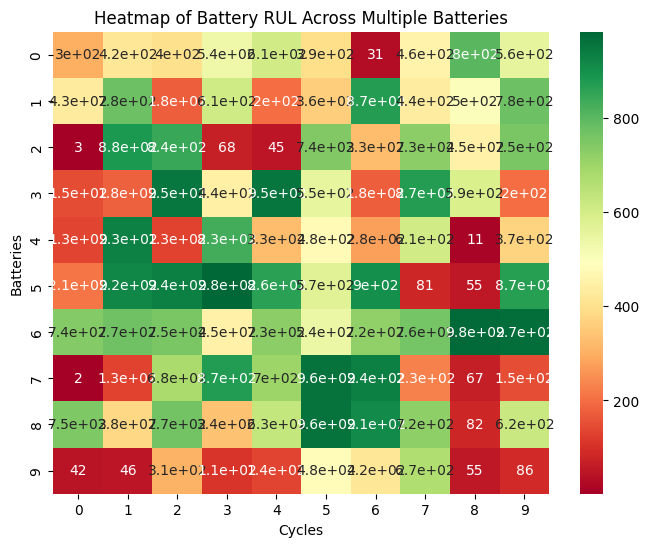


--- Heatmap Explanation ---
The heatmap provides a visualization of the RUL across multiple batteries and cycles.
The color gradient indicates battery health: Green for good health, Yellow for warning, and Red for critical condition.



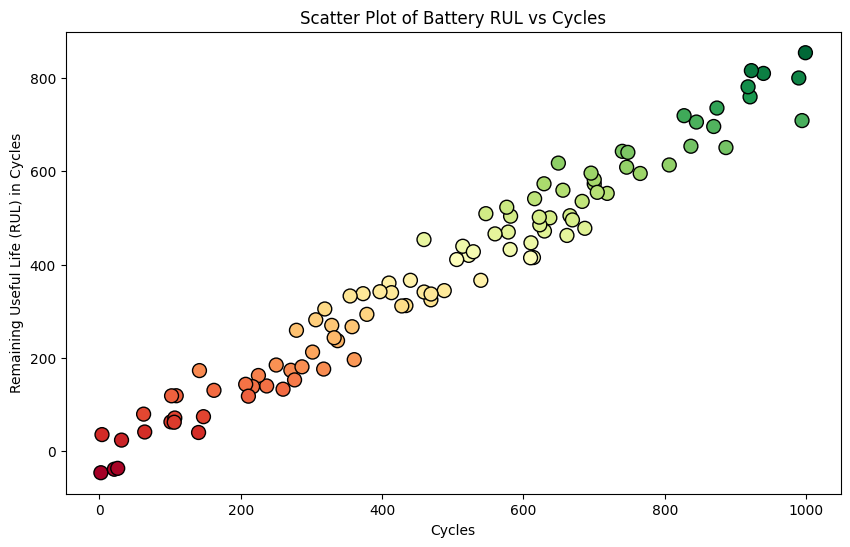


--- Scatter Plot Explanation ---
This scatter plot shows the relationship between cycles and the predicted RUL.
The color of the points indicates battery health: Green points represent good health, Yellow represents warning, and Red indicates critical condition.



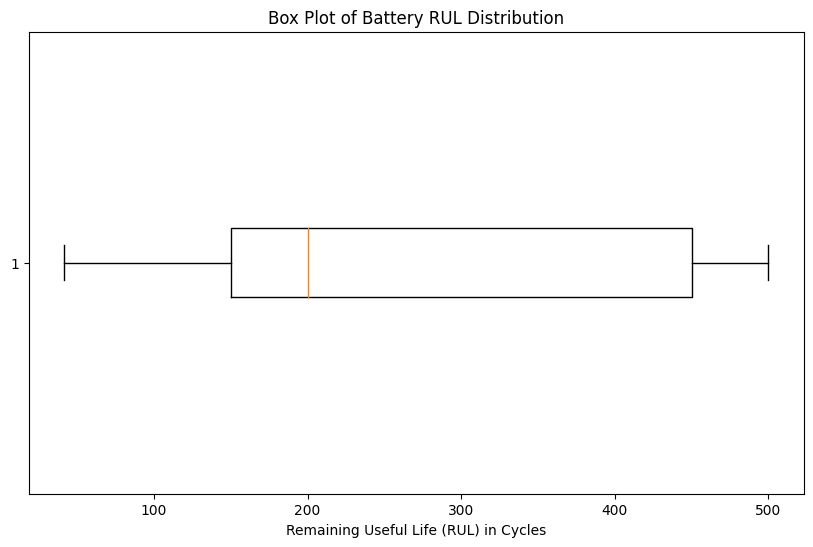


--- Box Plot Explanation ---
The box plot shows the distribution of RUL values for several batteries.
This helps visualize the spread and variability of RUL, including the minimum, maximum, and potential outliers in the data.



In [43]:
if 'model_pipeline' in locals() and 'X_train' in locals() and not X_train.empty:

    print("--- Feature Value Guidance (from Training Data X_train) ---")
    print(X_train.describe())
    print("-" * 50)

    print("\nEnter your custom feature values below:")
    default_f3 = X_train['F3'].mean() 
    default_f4 = X_train['F4'].mean()
    default_f5 = X_train['F5'].mean()

    try:
        input_f3 = float(input(f"Enter value for F3 (Max. Voltage Dischar. (V)) [e.g., {default_f3:.2f}]: ") or default_f3)
        input_f4 = float(input(f"Enter value for F4 (Min. Voltage Charg. (V))  [e.g., {default_f4:.2f}]: ") or default_f4)
        input_f5 = float(input(f"Enter value for F5 (Time at 4.15V (s))     [e.g., {default_f5:.0f}]: ") or default_f5)
    except ValueError:
        print("Invalid input. Using mean values as default for this test run.")
        input_f3 = default_f3
        input_f4 = default_f4
        input_f5 = default_f5

    custom_input_values = {
        'F3': input_f3,
        'F4': input_f4,
        'F5': input_f5
    }

    custom_input_df = pd.DataFrame([custom_input_values], columns=X_train.columns)

    print("\n--- Custom Input DataFrame ---")
    print(custom_input_df)
    print("-" * 50)

    predicted_rul = model_pipeline.predict(custom_input_df)

    print("\n--- Prediction ---")
    print(f"Predicted RUL: {predicted_rul[0]:.0f} cycles")
    print("-" * 50)

    threshold_good = 0.4 * predicted_rul[0] 
    threshold_warning = 0.2 * predicted_rul[0] 

    if predicted_rul[0] > threshold_good:
        battery_condition = "Good: The battery is in good condition and has a lot of cycles left."
    elif predicted_rul[0] > threshold_warning:
        battery_condition = "Warning: The battery is starting to degrade. Consider planning for replacement soon."
    else:
        battery_condition = "Needs Service: The battery is significantly degraded and may fail soon."

    print(f"Battery condition based on predicted RUL: {battery_condition}")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    time = [0, predicted_rul[0]]
    rul = [predicted_rul[0], predicted_rul[0]]
    ax.plot(time, rul, label="Predicted RUL", color='blue', linestyle='-', linewidth=2)
    ax.fill_between(time, rul, 600, where=(rul >= threshold_good), color='green', alpha=0.3, label='Good Battery')
    ax.fill_between(time, rul, threshold_good, where=((rul < threshold_good) & (rul >= threshold_warning)), color='yellow', alpha=0.3, label='Warning')
    ax.fill_between(time, rul, threshold_warning, where=(rul < threshold_warning), color='red', alpha=0.3, label='Needs Service')
    ax.set_title("Remaining Useful Life (RUL) Prediction and Battery Condition")
    ax.set_xlabel("Cycles")
    ax.set_ylabel("Remaining Useful Life (RUL) in Cycles")
    ax.legend(loc='best')
    plt.show()
    print("\n--- Line Plot Explanation ---")
    print("This line plot visualizes the predicted Remaining Useful Life (RUL) of the battery.")
    print(f"The battery is considered: {battery_condition}")
    print("As we can see, the battery's health is depicted by different color-coded sections: Green for good condition, Yellow for warning, and Red for critical condition.\n")

    
    fig, ax = plt.subplots(figsize=(10, 6))
    cycles = [10, 100, 250, 400, 600]  # Example cycles for multiple units
    rul_values = [predicted_rul[0], 500, 450, 200, 150]  # Example RUL predictions
    ax.bar(cycles, rul_values, color=['green' if r > threshold_good else 'yellow' if r > threshold_warning else 'red' for r in rul_values])
    ax.set_xlabel("Cycles")
    ax.set_ylabel("Remaining Useful Life (RUL) in Cycles")
    ax.set_title("Comparison of Battery RUL Across Units")
    plt.show()
    print("\n--- Bar Chart Explanation ---")
    print("This bar chart compares the predicted RUL of multiple battery units at different cycle points.")
    print("The color of the bars indicates the condition of each battery: Green for good, Yellow for warning, and Red for critical.\n")

    
    data = np.random.rand(10, 10) * 1000  # Simulated data for 10 batteries over 10 cycles
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(data, cmap='RdYlGn', annot=True, cbar=True, ax=ax)
    ax.set_xlabel("Cycles")
    ax.set_ylabel("Batteries")
    ax.set_title("Heatmap of Battery RUL Across Multiple Batteries")
    plt.show()
    print("\n--- Heatmap Explanation ---")
    print("The heatmap provides a visualization of the RUL across multiple batteries and cycles.")
    print("The color gradient indicates battery health: Green for good health, Yellow for warning, and Red for critical condition.\n")


    
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.random.rand(100) * 1000  # Example cycles
    y = x * 0.8 + np.random.randn(100) * 50  # Example RUL prediction with some noise
    ax.scatter(x, y, c=y, cmap='RdYlGn', edgecolor='black', s=100)
    ax.set_xlabel("Cycles")
    ax.set_ylabel("Remaining Useful Life (RUL) in Cycles")
    ax.set_title("Scatter Plot of Battery RUL vs Cycles")
    plt.show()
    print("\n--- Scatter Plot Explanation ---")
    print("This scatter plot shows the relationship between cycles and the predicted RUL.")
    print("The color of the points indicates battery health: Green points represent good health, Yellow represents warning, and Red indicates critical condition.\n")


    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.boxplot(rul_values, vert=False)
    ax.set_xlabel("Remaining Useful Life (RUL) in Cycles")
    ax.set_title("Box Plot of Battery RUL Distribution")
    plt.show()

    print("\n--- Box Plot Explanation ---")
    print("The box plot shows the distribution of RUL values for several batteries.")
    print("This helps visualize the spread and variability of RUL, including the minimum, maximum, and potential outliers in the data.\n")

else:
    print("\nModel pipeline or X_train is not available. Please train the model first.")
